# Assignment 1

Irfan Nur Afif

Timothy Aerts

In [1]:
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
from __future__ import division

c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'#'analogy_alice.txt'
corpus = open(path).readlines()[0:700]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1

# Is this something they need to change?
dim = 100
window_size = 2 #use this window size for Skipgram, CBOW, and the model with the additional hidden layer
window_size_corpus = 4 #use this window size for the co-occurrence matrix

## Question 1

### Co-occurrence Matrix
Use the provided code to load the "Alice in Wonderland" text document. 
1. Implement the word-word co-occurrence matrix for “Alice in Wonderland”
2. Normalize the words such that every value lies within a range of 0 and 1
3. Compute the cosine distance between the given words:
    - Alice 
    - Dinah
    - Rabbit
4. List the 5 closest words to 'Alice'. Discuss the results.
5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions?


## 1.1 
### Implement the word-word co-occurrence matrix for “Alice in Wonderland”

In [3]:
import scipy.sparse, numpy


vocabulary={}
data=[]
row=[]
col=[]
for sentence in corpus:
    for pos,word in enumerate(sentence):
        i=vocabulary.setdefault(word,len(vocabulary))
        start=max(0,pos-window_size_corpus)
        end=min(len(sentence),pos+window_size_corpus+1)
        for pos2 in range(start,end):
            if pos2==pos: 
                continue
            j=vocabulary.setdefault(sentence[pos2],len(vocabulary))
            if(j!=i):
                data.append(1.); row.append(i); col.append(j);
            
cooccurrence_matrix=scipy.sparse.coo_matrix((data,(row,col)))
#print(cooccurrence_matrix.T * cooccurrence_matrix)
print(cooccurrence_matrix.toarray())


[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 8. ... 0. 0. 0.]
 [1. 8. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 1.2 
### Normalize the words such that every value lies within a range of 0 and 1

In [64]:
#We use TF for normalization

cooc=cooccurrence_matrix.toarray()
tf_cooc=numpy.zeros((V-1, V-1))
for i, sentence in enumerate(cooc):
    sumf=0
    for wordf in sentence:
        sumf+=wordf
    for j,wordf in enumerate(sentence):
        if(sumf>0):
            tf_cooc[i][j]=cooc[i][j]/sumf
        else:
            continue
print(tf_cooc)

[[0.         0.0625     0.0625     ... 0.         0.         0.        ]
 [0.00105485 0.         0.00843882 ... 0.         0.         0.        ]
 [0.00381679 0.03053435 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


## 1.3 
### Compute the cosine distance between the given words: Alice, Dinah, Rabbit

In [204]:
#find cosine similarity to Alice, Dinah and Rabbit
import math
def cos_sim(a,b):
    return cosine_similarity([a],[b])[0][0]
    #sum_c=0;len_c=len(a);sum_as=0;sum_bs=0;
    #for ii in range(len_c):
    #    sum_c=sum_c+(a[ii]*b[ii])
    #    sum_as=sum_as+(a[ii]*a[ii])
    #    sum_bs=sum_bs+(b[ii]*b[ii])
    #if(sum_as==0 and sum_bs==0):
    #    return 1
    #else:
    #    return sum_c/(math.sqrt(sum_as)*(math.sqrt(sum_bs)))


print(tokenizer.word_index['alice'])  #11-1=10, since word_index starting at index 1
print(tokenizer.word_index['dinah'])  #87-1=86
print(tokenizer.word_index['rabbit']) #63-1=62

from sklearn.metrics.pairwise import cosine_similarity
#print(cosine_similarity(tf_cooc[10:11], tf_cooc[86:87]))
print("Cosine similarity of Alice and Dinah: {}".format(cos_sim(tf_cooc[10],tf_cooc[86])))                 
#print(cosine_similarity(tf_cooc[10:11], tf_cooc[62:63]))
print("Cosine similarity of Alice and Rabbit: {}".format(cos_sim(tf_cooc[10],tf_cooc[62])))
#print(cosine_similarity(tf_cooc[86:87], tf_cooc[62:63]))
print("Cosine similarity of Dinah and Rabbit: {}".format(cos_sim(tf_cooc[62],tf_cooc[86])))



11
87
63
Cosine similarity of Alice and Dinah: 0.48967327730053256
Cosine similarity of Alice and Rabbit: 0.08862667920586557
Cosine similarity of Dinah and Rabbit: 0.13969968905677818


## 1.4
### List the 5 closest words to 'Alice'. Discuss the results.

In [263]:
#find the closest words to Alice
maxid=0
maxval=0
simi=np.zeros(V-1)
for i in range(V-1):
    simi[i]=cosine_similarity(tf_cooc[10:11], tf_cooc[i:i+1])[0][0]
indices=simi.argsort()[-6:][::-1]
print("closest word= {}, {}, {}, {}, {}".format(list(tokenizer.word_index)[indices[1]],list(tokenizer.word_index)[indices[2]],list(tokenizer.word_index)[indices[3]],list(tokenizer.word_index)[indices[4]],list(tokenizer.word_index)[indices[5]]))            
for i in range(1,6):
    print("Cosine similarity of Alice and {}: {}".format(list(tokenizer.word_index)[indices[i]],cosine_similarity(tf_cooc[10:11], tf_cooc[indices[i]:indices[i]+1])[0][0]))


closest word= t, had, question, say, to
Cosine similarity of Alice and t: 0.7033898864296415
Cosine similarity of Alice and had: 0.6995182846911174
Cosine similarity of Alice and question: 0.6726422527548841
Cosine similarity of Alice and say: 0.6685274041392557
Cosine similarity of Alice and to: 0.6544770424322105


The closest words from alice are mainly verbs (had, question, say) and preposition (such as to). This is expected since a sentence usually have subject then followed by verb and sometimes preposition. In this case, Alice is mostly appear as subject in the text. The most frequent one is 't' because it is an abbreviation of 'not'. Usually the sentence goes like "Alice doesn't ..." or "Alice wouldn't..." and the 't' in this case was parsed into a word. Thus it is not surpising it becomes the closest word to Alice.

## 1.5
### Discuss what the main drawbacks are of a term-term co-occurence matrix solutions?

The main drawbacks of co-occurance matrix is the resulting matrix is sparse (contains a lot of 0 values). This is not an efficient representation since it costs a lot of memory (VxV, where V is the number of unique word) to store a lot of 0 values. Moreover, if we add a new word to corpus, then the amount of table value that will be added is $V^2-(V-1)^2$ which is a lot for big number of V. The resulting matrix also storing the same values on the upper and lower side of main diagonal, which is somewhat redundant.  Lastly the frequency of occurrence can be skewed and non discriminative.

In [74]:
#Save your all the vector representations of your word embeddings in this way
#Change when necessary the sizes of the vocabulary/embedding dimension

f = open('vectors_co_occurrence.txt',"w")
f.write(" ".join([str(V-1),str(V-1)]))
f.write("\n")

#vectors = your word co-occurrence matrix
vectors = tf_cooc
for word, i in tokenizer.word_index.items():    
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i-1,:]))))
    f.write("\n")
f.close()

In [259]:
#reopen your file as follows

co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)

## Question 2

### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the CBOW model
2. Using Skipgram model
3. Add extra hidden dense layer to CBow and Skipgram implementations. Choose an activation function for that layer and justify your answer.
4. Analyze the four different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings that you have trained in 2.1, 2.2 and 2.3.  
    - Visualize your results and interpret your results
5. Use the word co-occurence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings.  
6. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What is the advantage of negative sampling?
    - What are the main drawbacks of CBOW and Skipgram?
7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300
    - Compare performance on the analogy task with your own trained embeddings from "Alice in Wonderland". You can limit yourself to the vocabulary of Alice in Wonderland. Visualize the pre-trained word embeddings and compare these with the results of your own trained word embeddings. 


## 2.1
### Using the CBOW model

In [4]:
#prepare data for cbow
path = 'alice.txt'
corpus = open(path).readlines()
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1

def prep_cbow_data(corpus=corpus,window_size=window_size,V=V):
    x = []
    y = []
    w = window_size
    for sentence in corpus:
        word_length = len(sentence)
        if word_length >4:
            start = w
            for i in range(w,word_length-w):
                context_before = sentence[i-w:i]
                target = np.zeros(V,dtype=int)
                target[sentence[i]] = 1
                context_after = sentence[i+1:i+1+start]
                context = context_before + context_after
                if len(context) == 4:
                    #onehot_context = np.asarray(onehot_context)
                    x.append(context)
                    y.append(target)
        else:
            pass
    x = np.asarray(x)
    y = np.asarray(y)
    return x,y

print(prep_cbow_data()[0].shape)
print(prep_cbow_data()[1].shape)
print(V)





(17896, 4)
(17896, 2557)
2557


In [8]:
#create CBOW model
from keras.layers import Flatten
#X,Y = prep_cbow_data()
#features = len(X)
#print("size X: {},size Y:{}".format(len(X),len(Y)))
#print(X.shape,Y.shape)
cbow_50 = Sequential(name="cbow50")
cbow_50.add(Embedding(input_dim=V, output_dim=50, init='glorot_uniform',input_length=4))
cbow_50.add(Flatten())
cbow_50.add(Dense(V, init='glorot_uniform', activation='softmax'))

cbow_50.summary()
cbow_150 = Sequential(name="cbow150")
cbow_150.add(Embedding(input_dim=V, output_dim=150, init='glorot_uniform',input_length=4))
cbow_150.add(Flatten())
cbow_150.add(Dense(V, init='glorot_uniform', activation='softmax'))
cbow_150.summary()

cbow_300 = Sequential(name="cbow300")
cbow_300.add(Embedding(input_dim=V, output_dim=300, init='glorot_uniform',input_length=4))
cbow_300.add(Flatten())
cbow_300.add(Dense(V, init='glorot_uniform', activation='softmax'))
cbow_300.summary()

cbow_models = [cbow_50,cbow_150,cbow_300]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 4, 50)             127850    
_________________________________________________________________
flatten_4 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2557)              513957    
Total params: 641,807
Trainable params: 641,807
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 4, 150)            383550    
_________________________________________________________________
flatten_5 (Flatten)          (None, 600)               0         
_________________________________________________________________
dens

c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=2557, output_dim=50, input_length=4, embeddings_initializer="glorot_uniform")`
  
c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2557, activation="softmax", kernel_initializer="glorot_uniform")`
  # Remove the CWD from sys.path while we load stuff.
c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=2557, output_dim=150, input_length=4, embeddings_initializer="glorot_uniform")`
  
c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2557, activation="softmax", 

In [9]:
#define loss function
for cbow in cbow_models:
    cbow.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [10]:
#train model
from keras import callbacks
X,Y = prep_cbow_data()
epochs=100
b_size = 250
earlyStopping=callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001, patience=0, verbose=0, mode='auto')
trained_models = []
for cbow in cbow_models:
    print("Running {}".format(cbow.name))
    cbow.fit(X,Y,batch_size=b_size,epochs=epochs,validation_split=1/12, callbacks=[earlyStopping])
    cbow.save(cbow.name+".h5")


Running cbow50
Train on 16404 samples, validate on 1492 samples
Epoch 1/100
16404/16404 [==============================] - 6s 340us/step - loss: 7.8331 - val_loss: 7.8205
Epoch 2/100
16404/16404 [==============================] - 5s 294us/step - loss: 7.8028 - val_loss: 7.7908
Epoch 3/100
16404/16404 [==============================] - 5s 295us/step - loss: 7.7638 - val_loss: 7.7437
Epoch 4/100
16404/16404 [==============================] - 5s 295us/step - loss: 7.6958 - val_loss: 7.6447
Epoch 5/100
16404/16404 [==============================] - 5s 295us/step - loss: 7.5512 - val_loss: 7.4205
Epoch 6/100
16404/16404 [==============================] - 5s 296us/step - loss: 7.2535 - val_loss: 7.0241
Epoch 7/100
16404/16404 [==============================] - 5s 296us/step - loss: 6.8873 - val_loss: 6.7400
Epoch 8/100
16404/16404 [==============================] - 5s 297us/step - loss: 6.6217 - val_loss: 6.5538
Epoch 9/100
16404/16404 [==============================] - 5s 297us/step - loss:

16404/16404 [==============================] - 5s 294us/step - loss: 3.5477 - val_loss: 4.9687
Epoch 77/100
16404/16404 [==============================] - 5s 293us/step - loss: 3.5274 - val_loss: 4.9644
Epoch 78/100
16404/16404 [==============================] - 5s 294us/step - loss: 3.5073 - val_loss: 4.9626
Epoch 79/100
16404/16404 [==============================] - 5s 294us/step - loss: 3.4875 - val_loss: 4.9581
Epoch 80/100
16404/16404 [==============================] - 5s 296us/step - loss: 3.4677 - val_loss: 4.9551
Epoch 81/100
16404/16404 [==============================] - 5s 294us/step - loss: 3.4482 - val_loss: 4.9530
Epoch 82/100
16404/16404 [==============================] - 5s 295us/step - loss: 3.4287 - val_loss: 4.9502
Epoch 83/100
16404/16404 [==============================] - 5s 294us/step - loss: 3.4095 - val_loss: 4.9482
Epoch 84/100
16404/16404 [==============================] - 5s 295us/step - loss: 3.3903 - val_loss: 4.9464
Epoch 85/100
16404/16404 [===============

Epoch 6/100
16404/16404 [==============================] - 11s 669us/step - loss: 6.4301 - val_loss: 6.3627
Epoch 7/100
16404/16404 [==============================] - 11s 673us/step - loss: 6.1293 - val_loss: 6.1634
Epoch 8/100
16404/16404 [==============================] - 11s 671us/step - loss: 5.8904 - val_loss: 6.0110
Epoch 9/100
16404/16404 [==============================] - 11s 673us/step - loss: 5.6911 - val_loss: 5.8874
Epoch 10/100
16404/16404 [==============================] - 11s 674us/step - loss: 5.5191 - val_loss: 5.7851
Epoch 11/100
16404/16404 [==============================] - 11s 673us/step - loss: 5.3677 - val_loss: 5.6999
Epoch 12/100
16404/16404 [==============================] - 11s 674us/step - loss: 5.2318 - val_loss: 5.6226
Epoch 13/100
16404/16404 [==============================] - 11s 674us/step - loss: 5.1090 - val_loss: 5.5536
Epoch 14/100
16404/16404 [==============================] - 11s 672us/step - loss: 4.9963 - val_loss: 5.4946
Epoch 15/100
16404/1640

In [ ]:
for model in trained_models:
    model.save(model.name +'.h5')

# 2.2 
## Using the Skipgram model.

In [163]:
#prepare data for Skipgram
def generate_data_skipgram(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
                    
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    in_words.append([word])
                    labels.append(words[i])
            if in_words != []:
                all_in.append(np.array(in_words,dtype=np.int32))
                all_out.append(np_utils.to_categorical(labels, V))
    return (all_in,all_out)

#get x and y's for data
x,y = generate_data_skipgram(corpus,window_size,V)

#save the preprocessed data of Skipgram
f = open('data_skipgram.txt' ,'w')

for input,outcome  in zip(x,y):
    input = np.concatenate(input)
    f.write(" ".join(map(str, list(input))))
    f.write(",")
    outcome = np.concatenate(outcome)
    f.write(" ".join(map(str,list(outcome))))
    f.write("\n")
f.close()

#load the preprocessed Skipgram data
def generate_data_skipgram_from_file():
    f = open('data_skipgram.txt' ,'r')
    for row in f:
        inputs,outputs = row.split(",")
        inputs = np.fromstring(inputs, dtype=int, sep=' ')
        inputs = np.asarray(np.split(inputs, len(inputs)))
        outputs = np.fromstring(outputs, dtype=float, sep=' ')
        outputs = np.asarray(np.split(outputs, len(inputs)))
        yield (inputs,outputs)

In [164]:
#create Skipgram model

dim1=50
dim2=150
dim3=300
skipgram_50 = Sequential()
skipgram_50.add(Embedding(input_dim=V, output_dim=dim1, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_50.add(Reshape((dim1, )))
skipgram_50.add(Dense(input_dim=dim1, units=V, kernel_initializer='uniform', activation='softmax'))

skipgram_150 = Sequential()
skipgram_150.add(Embedding(input_dim=V, output_dim=dim2, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_150.add(Reshape((dim2, )))
skipgram_150.add(Dense(input_dim=dim2, units=V, kernel_initializer='uniform', activation='softmax'))

skipgram_300 = Sequential()
skipgram_300.add(Embedding(input_dim=V, output_dim=dim3, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_300.add(Reshape((dim3, )))
skipgram_300.add(Dense(input_dim=dim3, units=V, kernel_initializer='uniform', activation='softmax'))

In [165]:
#define loss function for Skipgram
skipgram_50.compile(loss='categorical_crossentropy', optimizer='adadelta')
skipgram_150.compile(loss='categorical_crossentropy', optimizer='adadelta')
skipgram_300.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [166]:
#train Skipgram model
for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram_50.train_on_batch(x, y)

    print(ite, loss)
    
f = open('vectors_skipgram_50.txt' ,'w')
f.write(" ".join([str(V-1),str(dim1)]))
f.write("\n")
vectors = skipgram_50.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram_150.train_on_batch(x, y)

    print(ite, loss)
    
f = open('vectors_skipgram_150.txt' ,'w')
f.write(" ".join([str(V-1),str(dim2)]))
f.write("\n")
vectors = skipgram_150.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram_300.train_on_batch(x, y)

    print(ite, loss)
    
f = open('vectors_skipgram_300.txt' ,'w')
f.write(" ".join([str(V-1),str(dim3)]))
f.write("\n")
vectors = skipgram_300.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

0 42020.850971221924
1 38379.24893140793
2 39009.6740334034
3 39515.18972373009
4 39694.606760025024
5 39879.188750982285
6 40052.81768655777
7 40222.94297456741
8 40406.03855037689
9 40601.82211446762
0 41999.72671556473
1 38329.860137462616
2 38863.99836754799
3 39224.9512283802
4 39388.4169280529
5 39532.090304374695
6 39681.889948129654
7 39846.23095178604
8 40013.75022268295
9 40184.366864323616
0 41972.11958169937
1 38265.37358021736
2 38667.456391334534
3 38952.51325392723
4 39107.2551445961
5 39254.421288490295
6 39401.511434555054
7 39544.53228521347
8 39688.97990846634
9 39832.670347929


## 2.3
### Add extra hidden dense layer to CBow and Skipgram implementations. Choose an activation function for that layer and justify your answer.

In [8]:
#create CBOW model with additional dense layer
dims = [50,150,300]
extended_models = []
for dim in dims:
    cbow = Sequential(name="cbow_extended_"+str(dim))
    cbow.add(Embedding(input_dim=V, output_dim=dim, init='glorot_uniform',input_length=4))
    cbow.add(Flatten())
    cbow.add(Dense(V,activation='relu',name="dense1"))
    cbow.add(Dense(V, init='glorot_uniform', activation='softmax'))
    extended_models.append(cbow)

c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=1183, output_dim=100, input_length=4, embeddings_initializer="glorot_uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1183, activation="softmax", kernel_initializer="glorot_uniform")`
  


In [10]:
#define loss function for CBOW + dense
for model in extended_models:
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [11]:
#train model for CBOW + dense
from keras import callbacks
X,Y = prep_cbow_data()
features = len(X)
print("size X: {},size Y:{}".format(len(X),len(Y)))
print(X.shape,Y.shape)
epochs=50
for model in extended_models:
    earlyStopping=callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')
    print("training {}".format(model.name))
    model.fit(X,Y,epochs=epochs,validation_split=0.1, callbacks=[earlyStopping])
    model.save(model.name+".h5")

Train on 5903 samples, validate on 656 samples
Epoch 1/100
5903/5903 [==============================] - 9s 2ms/step - loss: 6.7766 - val_loss: 6.1094
Epoch 2/100
5903/5903 [==============================] - 9s 1ms/step - loss: 5.8327 - val_loss: 5.7606
Epoch 3/100
5903/5903 [==============================] - 9s 2ms/step - loss: 5.5145 - val_loss: 5.5747
Epoch 4/100
5903/5903 [==============================] - 8s 1ms/step - loss: 5.2639 - val_loss: 5.4150
Epoch 5/100
5903/5903 [==============================] - 8s 1ms/step - loss: 5.0215 - val_loss: 5.2781
Epoch 6/100
5903/5903 [==============================] - 9s 2ms/step - loss: 4.7894 - val_loss: 5.1477
Epoch 7/100
5903/5903 [==============================] - 11s 2ms/step - loss: 4.5724 - val_loss: 5.0567
Epoch 8/100
5903/5903 [==============================] - 10s 2ms/step - loss: 4.3716 - val_loss: 4.9879
Epoch 9/100
5903/5903 [==============================] - 10s 2ms/step - loss: 4.1812 - val_loss: 4.9395
Epoch 10/100
5903/5903 

In [12]:
#create Skipgram with additional dense layer

#create Skipgram model

skipgram_50_dense = Sequential()
skipgram_50_dense.add(Embedding(input_dim=V, output_dim=dim1, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_50_dense.add(Reshape((dim1, )))
skipgram_50_dense.add(Dense(V,activation='relu'))
skipgram_50_dense.add(Dense(input_dim=dim1, units=V, kernel_initializer='uniform', activation='softmax'))

skipgram_150_dense = Sequential()
skipgram_150_dense.add(Embedding(input_dim=V, output_dim=dim2, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_150_dense.add(Reshape((dim2, )))
skipgram_150_dense.add(Dense(V,activation='relu'))
skipgram_150_dense.add(Dense(input_dim=dim2, units=V, kernel_initializer='uniform', activation='softmax'))

skipgram_300_dense = Sequential()
skipgram_300_dense.add(Embedding(input_dim=V, output_dim=dim3, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_300_dense.add(Reshape((dim3, )))
skipgram_300_dense.add(Dense(V,activation='relu'))
skipgram_300_dense.add(Dense(input_dim=dim3, units=V, kernel_initializer='uniform', activation='softmax'))



#skipgram2 = Sequential()
#skipgram2.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
#skipgram2.add(Reshape((dim, )))
#skipgram2.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))
#skipgram2.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

In [13]:
#define loss function for Skipgram + dense
skipgram_50_dense.compile(loss='categorical_crossentropy', optimizer='adadelta')
skipgram_150_dense.compile(loss='categorical_crossentropy', optimizer='adadelta')
skipgram_300_dense.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [14]:
#train model for Skipgram + dense
#train Skipgram model
for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram_50_dense.train_on_batch(x, y)

    print(ite, loss)
    
f = open('vectors_skipgram_50_dense.txt' ,'w')
f.write(" ".join([str(V-1),str(dim1)]))
f.write("\n")
vectors = skipgram_50_dense.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram_150_dense.train_on_batch(x, y)

    print(ite, loss)
    
f = open('vectors_skipgram_150_dense.txt' ,'w')
f.write(" ".join([str(V-1),str(dim2)]))
f.write("\n")
vectors = skipgram_150_dense.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram_300_dense.train_on_batch(x, y)

    print(ite, loss)
    
f = open('vectors_skipgram_300_dense.txt' ,'w')
f.write(" ".join([str(V-1),str(dim3)]))
f.write("\n")
vectors = skipgram_300_dense.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

0 39444.32987213135
1 38264.48951482773
2 37948.66480302811
3 37769.99622249603
4 37750.78943347931
5 37725.23108911514
6 37674.930666565895
7 37620.79466640949
8 37566.527002334595
9 37519.70512115955
0 39471.03422307968
1 38220.93018221855
2 37718.286794900894
3 37538.61131024361
4 37493.13153910637
5 37456.600872159004
6 37402.676347732544
7 37335.5792144537
8 37265.79830777645
9 37196.82523834705
0 39445.47623085976
1 38082.24569654465
2 37592.96987724304
3 37330.86567401886
4 37259.75267124176
5 37224.620362997055
6 37161.21744906902
7 37086.09090960026
8 37002.261269927025
9 36925.072355270386


In [ ]:
#save model
skipgram_50.save('skipgram_50.h5')
skipgram_150.save('skipgram_150.h5')
skipgram_300.save('skipgram_300.h5')
skipgram_50_dense.save('skipgram_50_dense.h5')
skipgram_150_dense.save('skipgram_150_dense.h5')
skipgram_300_dense.save('skipgram_300_dense.h5')

TODO:
explain activation layer

We add an extra hidden dense layer just before the final dense layer. We use ReLU activation function since it is the simplest non-linear activation function that is commonly used.

## 2.4
### Analyze the four different word embeddings

In [124]:
#Implement your own analogy function

key_cbow_50 ={}
key_cbow_150 ={}
key_cbow_300 ={}
key_cbow_50_dense ={}
key_cbow_150_dense ={}
key_cbow_300_dense ={}
key_skipgram_50 ={}
key_skipgram_150 ={}
key_skipgram_300 ={}
key_skipgram_50_dense ={}
key_skipgram_150_dense ={}
key_skipgram_300_dense ={}

embed_cbow_50 =[]
embed_cbow_150 =[]
embed_cbow_300 =[]
embed_cbow_50_dense =[]
embed_cbow_150_dense =[]
embed_cbow_300_dense =[]
embed_skipgram_50 =[]
embed_skipgram_150 =[]
embed_skipgram_300 =[]
embed_skipgram_50_dense =[]
embed_skipgram_150_dense =[]
embed_skipgram_300_dense =[]




def load_from_file(a):
    f = open(a ,'r')
    key_dict={}
    vect=[]
    for row in f:
        dimention=0
        inp = row.split("\n")[0].split(" ")
        if(len(inp)==2):
            dimention=inp[1]
        else:
            key_dict.update({inp[0]:len(key_dict)})
            vect.append(np.asarray(inp[1:],dtype=float))
    return (vect,key_dict)

(embed_cbow_50,key_cbow_50)=load_from_file('vectors_cbow_50.txt')
(embed_cbow_150,key_cbow_150)=load_from_file('vectors_cbow_150.txt')
(embed_cbow_300,key_cbow_300)=load_from_file('vectors_cbow_300.txt')
(embed_cbow_50_dense,key_cbow_50_dense)=load_from_file('vectors_cbow_50_dense.txt')
(embed_cbow_150_dense,key_cbow_150_dense)=load_from_file('vectors_cbow_150_dense.txt')
(embed_cbow_300_dense,key_cbow_300_dense)=load_from_file('vectors_cbow_300_dense.txt')
(embed_skipgram_50,key_skipgram_50)=load_from_file('vectors_skipgram_50.txt')
(embed_skipgram_150,key_skipgram_150)=load_from_file('vectors_skipgram_150.txt')
(embed_skipgram_300,key_skipgram_300)=load_from_file('vectors_skipgram_300.txt')
(embed_skipgram_50_dense,key_skipgram_50_dense)=load_from_file('vectors_skipgram_50_dense.txt')
(embed_skipgram_150_dense,key_skipgram_150_dense)=load_from_file('vectors_skipgram_150_dense.txt')
(embed_skipgram_300_dense,key_skipgram_300_dense)=load_from_file('vectors_skipgram_300_dense.txt')




In [287]:
import operator 
def load_analogy():
    f = open('analogy_alice.txt' ,'r')
    analogy_list=[]
    for row in f:
        a = row.split("\n")[0].split(" ")
        analogy_list.append(np.asarray(a))
    return analogy_list

def analogy_check(analogy_list,embed_matrix,dictionary):
    v=[[],[],[],[]]
    for i in range(4):
        if(analogy_list[i] in dictionary):
            v[i]=embed_matrix[dictionary[analogy_list[i]]-1]
        else:
            v[i]=np.zeros(len(embed_matrix[0]))
    #print(dictionary)
    #return abs(cos_sim(v[0],v[2])-cos_sim(v[1],v[3]))
    #return 1-abs(cos_sim(v[0],v[1])-cos_sim(v[2],v[3]))
    #return cos_sim( list(map(sum, zip(list(map(operator.sub, v[0],v[1]))), v[2])),v[3])
    #return abs(cos_sim(v[0]-v[2]+v[1],v[3]))
    return abs(cos_sim( (v[0]+v[1]),(v[2]+v[3])))


analogy_list=load_analogy()
#print(analogy_list[0])
print(analogy_check(["go","going","look","looking"],embed_skipgram_150, tokenizer.word_index ))
print(analogy_check(["say","saying","sit","sitting"],cooccurrence_matrix.toarray(), tokenizer.word_index ))
print(analogy_check(["sudden","suddenly","usual","usually"],embed_skipgram_300_dense, tokenizer.word_index ))
#print(analogy_check(["king","queen","man","woman"],embed_cbow_50, tokenizer.word_index ))

#analogy_check(["fancy","fancying","alice","rabbit"],embed_skipgram_150, tokenizer.word_index )    

0.3108869698881552
0.3173297559423709
0.0379434827632857


In [168]:
"king" in tokenizer.word_index

False

In [123]:
#read model from tim

from keras.models import load_model

dim1=50
dim2=150
dim3=300
cbow_50 = load_model('cbow50.h5')
cbow_150 = load_model('cbow150.h5')
cbow_300 = load_model('cbow300.h5')
cbow_50_dense = load_model('cbow_extended_50.h5')
cbow_150_dense = load_model('cbow_extended_150.h5')
cbow_300_dense = load_model('cbow_extended_300.h5')

f = open('vectors_cbow_50.txt' ,'w')
f.write(" ".join([str(V-1),str(dim1)]))
f.write("\n")
vectors = cbow_50.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

f = open('vectors_cbow_150.txt' ,'w')
f.write(" ".join([str(V-1),str(dim2)]))
f.write("\n")
vectors = cbow_150.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

f = open('vectors_cbow_300.txt' ,'w')
f.write(" ".join([str(V-1),str(dim3)]))
f.write("\n")
vectors = cbow_300.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

f = open('vectors_cbow_50_dense.txt' ,'w')
f.write(" ".join([str(V-1),str(dim1)]))
f.write("\n")
vectors = cbow_50_dense.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

f = open('vectors_cbow_150_dense.txt' ,'w')
f.write(" ".join([str(V-1),str(dim2)]))
f.write("\n")
vectors = cbow_150_dense.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

f = open('vectors_cbow_300_dense.txt' ,'w')
f.write(" ".join([str(V-1),str(dim3)]))
f.write("\n")
vectors = cbow_300_dense.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()


In [288]:
#w2v and glove analogy performance
cbow50analogylist=[]
cbow50denseanalogylist=[]
cbow150analogylist=[]
cbow150denseanalogylist=[]
cbow300analogylist=[]
cbow300denseanalogylist=[]
skipgram50analogylist=[]
skipgram50denseanalogylist=[]
skipgram150analogylist=[]
skipgram150denseanalogylist=[]
skipgram300analogylist=[]
skipgram300denseanalogylist=[]
co_occurrencelist=[]


for analogy in analogy_list:
    if(analogy[0] in tokenizer.word_index and analogy[1] in tokenizer.word_index and analogy[2] in tokenizer.word_index and analogy[3] in tokenizer.word_index):
        try:
            co_occurrenceanalogy=analogy_check(analogy,tf_cooc, tokenizer.word_index )
            cbow50analogy=analogy_check(analogy,embed_cbow_50, tokenizer.word_index )
            cbow150analogy=analogy_check(analogy,embed_cbow_150, tokenizer.word_index )
            cbow300analogy=analogy_check(analogy,embed_cbow_300, tokenizer.word_index )
            cbow50denseanalogy=analogy_check(analogy,embed_cbow_50_dense, tokenizer.word_index )
            cbow150denseanalogy=analogy_check(analogy,embed_cbow_150_dense, tokenizer.word_index )
            cbow300denseanalogy=analogy_check(analogy,embed_cbow_300_dense, tokenizer.word_index )
            skipgram50analogy=analogy_check(analogy,embed_skipgram_50, tokenizer.word_index )
            skipgram150analogy=analogy_check(analogy,embed_skipgram_150, tokenizer.word_index )
            skipgram300analogy=analogy_check(analogy,embed_skipgram_300, tokenizer.word_index )
            skipgram50denseanalogy=analogy_check(analogy,embed_skipgram_50_dense, tokenizer.word_index )
            skipgram150denseanalogy=analogy_check(analogy,embed_skipgram_150_dense, tokenizer.word_index )
            skipgram300denseanalogy=analogy_check(analogy,embed_skipgram_300_dense, tokenizer.word_index )
            
            
            
            print("cbow_50: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],cbow50analogy))
            print("cbow_150: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],cbow150analogy))
            print("cbow_300: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],cbow300analogy))
            print("cbow_50_dense: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],cbow50denseanalogy))
            print("cbow_150_dense: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],cbow150denseanalogy))
            print("cbow_300_dense: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],cbow300denseanalogy))
            print("skipgram_50: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],skipgram50analogy))
            print("skipgram_150: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],skipgram150analogy))
            print("skipgram_300: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],skipgram300analogy))
            print("skipgram_50_dense: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],skipgram50denseanalogy))
            print("skipgram_150_dense: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],skipgram150denseanalogy))
            print("skipgram_300_dense: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],skipgram300denseanalogy))
            
            
            co_occurrencelist.append(co_occurrence)
            cbow50analogylist.append(cbow50analogy)
            cbow150analogylist.append(cbow150analogy)
            cbow300analogylist.append(cbow300analogy)
            cbow50denseanalogylist.append(cbow50denseanalogy)
            cbow150denseanalogylist.append(cbow150denseanalogy)
            cbow300denseanalogylist.append(cbow300denseanalogy)
            skipgram50analogylist.append(skipgram50analogy)
            skipgram150analogylist.append(skipgram150analogy)
            skipgram300analogylist.append(skipgram300analogy)
            skipgram50denseanalogylist.append(skipgram50denseanalogy)
            skipgram150denseanalogylist.append(skipgram150denseanalogy)
            skipgram300denseanalogylist.append(skipgram300denseanalogy)
            
            
            print()
        except KeyError:
            continue
    



cbow_50: sudden, suddenly, usual, usually: 0.2145599465610109
cbow_150: sudden, suddenly, usual, usually: 0.16464666681544313
cbow_300: sudden, suddenly, usual, usually: 0.04262983580543956
cbow_50_dense: sudden, suddenly, usual, usually: 0.024934976086477847
cbow_150_dense: sudden, suddenly, usual, usually: 0.06584301080295592
cbow_300_dense: sudden, suddenly, usual, usually: 0.057512587300851306
skipgram_50: sudden, suddenly, usual, usually: 0.051247048932523284
skipgram_150: sudden, suddenly, usual, usually: 0.11488630353144216
skipgram_300: sudden, suddenly, usual, usually: 0.025398620492292738
skipgram_50_dense: sudden, suddenly, usual, usually: 0.11550091531896342
skipgram_150_dense: sudden, suddenly, usual, usually: 0.09122986493247628
skipgram_300_dense: sudden, suddenly, usual, usually: 0.0379434827632857

cbow_50: bad, worse, good, better: 0.007139452508570647
cbow_150: bad, worse, good, better: 0.04960375886754415
cbow_300: bad, worse, good, better: 0.08364212988123694
cbow_

Comparison performance:

In [226]:
#Visualization results trained word embeddings

import matplotlib.pyplot as plt
def draw_word_vecs(X,strings):
    col = ['r','b','g','y']
    if len(X)!= len(strings):
        print("mismatch in lengths between labels and vectors")
        
    X_embedded = TSNE(n_components=4,method='exact').fit_transform(X)
    maxt = np.amax(X_embedded)
    mint = np.amin(X_embedded)
    #print(maxt,mint)
    maxt = max(maxt,mint*-1)
    for i in range(len(X_embedded)):
        plt.quiver(X_embedded[i][0]/maxt,X_embedded[i][1]/maxt,X_embedded[i][2]/maxt,X_embedded[i][3]/maxt,angles='xy', scale_units='xy',color=col[i], scale=1,label=strings[i])
        #for val in X_embedded[i]:
            #print(val/maxt)
    #print(X_embedded)
    plt.ylim(-1.2,1.2)
    plt.xlim(-1.2,1.2)
    plt.legend(strings)
    plt.show()



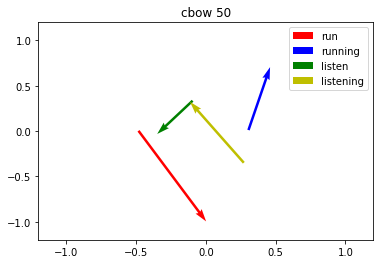

['run' 'running' 'listen' 'listening']


In [316]:
#cbow 50

w2visualize=analogy_list[42]
embedlist=[]
for i in range(4):
    #embedlist.append(word2vec[analogy_list[1][i]])
    embedlist.append(embed_cbow_50[tokenizer.word_index[w2visualize[i]]-1])
plt.title("cbow 50")
draw_word_vecs(embedlist,w2visualize)    
print(w2visualize)


We made a function analogy_check() for checking how similar a set of analogy is. For an analogy, we will have a set of embedding vector (v0, v1, v2, v3). The way we checked it by checking cosine_similarity of (v0+v1) and (v2+v3). If it is an analogy, then the cosine should be high because (v0+v1) and (v2+v3) should be closed (in terms of cosine angle) with each other.

Overall, the performance is not satisfying. This could be caused by several factors: inadequate training sample, the world in analogy is not frequently appear, etc. Adding more dimension in embedding vector also doesn't prove to increase the similarity. Most of the analogy works better for n=50 compared to n=150 or 300. Adding dense layer also doens not prove to increase similarity. The extra training time for adding dense layer is not improving the similarity of an analogy (but there is few that improves such as (large, largest, good, best) on cbow_50 and cbow_50_dense)

CBOW works better on frequent word. For example (eat, eats, find, finds) cbow_50 is better than skipgram_50. In alice.txt there are more than 100 occurance of 'eat' word. CBOW better in this case because context words are averaged before predicting the targeted word, and since it has more sample then it works better in this case. This means Skipgram is better on rare words.

One of the highest one (run, running, listen, listening) by cbow with dim=50. As we can see in the picture above, the red and blue arrow are almost 90$0$ from each other and so does the green and yellow arrow. So when the cosine_similarity was used for the resultant of both vectors, then it should produce a close similarity. 

## 2.5
### Use the word co-occurence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings.

In [280]:
#w2v and glove analogy performance
cbow50analogylist=[]
cbow50denseanalogylist=[]
cbow150analogylist=[]
cbow150denseanalogylist=[]
cbow300analogylist=[]
cbow300denseanalogylist=[]
skipgram50analogylist=[]
skipgram50denseanalogylist=[]
skipgram150analogylist=[]
skipgram150denseanalogylist=[]
skipgram300analogylist=[]
skipgram300denseanalogylist=[]
co_occurrencelist=[]


for analogy in analogy_list:
    if(analogy[0] in tokenizer.word_index and analogy[1] in tokenizer.word_index and analogy[2] in tokenizer.word_index and analogy[3] in tokenizer.word_index):
        try:
            co_occurrenceanalogy=analogy_check(analogy,tf_cooc, tokenizer.word_index )
            cbow50analogy=analogy_check(analogy,embed_cbow_50, tokenizer.word_index )
            cbow150analogy=analogy_check(analogy,embed_cbow_150, tokenizer.word_index )
            cbow300analogy=analogy_check(analogy,embed_cbow_300, tokenizer.word_index )
            cbow50denseanalogy=analogy_check(analogy,embed_cbow_50_dense, tokenizer.word_index )
            cbow150denseanalogy=analogy_check(analogy,embed_cbow_150_dense, tokenizer.word_index )
            cbow300denseanalogy=analogy_check(analogy,embed_cbow_300_dense, tokenizer.word_index )
            skipgram50analogy=analogy_check(analogy,embed_skipgram_50, tokenizer.word_index )
            skipgram150analogy=analogy_check(analogy,embed_skipgram_150, tokenizer.word_index )
            skipgram300analogy=analogy_check(analogy,embed_skipgram_300, tokenizer.word_index )
            skipgram50denseanalogy=analogy_check(analogy,embed_skipgram_50_dense, tokenizer.word_index )
            skipgram150denseanalogy=analogy_check(analogy,embed_skipgram_150_dense, tokenizer.word_index )
            skipgram300denseanalogy=analogy_check(analogy,embed_skipgram_300_dense, tokenizer.word_index )
            
            
            
            print("co-occurance: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],co_occurrenceanalogy))
            print("cbow_50: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],cbow50analogy))
            print("cbow_150: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],cbow150analogy))
            print("cbow_300: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],cbow300analogy))
            print("cbow_50_dense: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],cbow50denseanalogy))
            print("cbow_150_dense: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],cbow150denseanalogy))
            print("cbow_300_dense: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],cbow300denseanalogy))
            print("skipgram_50: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],skipgram50analogy))
            print("skipgram_150: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],skipgram150analogy))
            print("skipgram_300: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],skipgram300analogy))
            print("skipgram_50_dense: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],skipgram50denseanalogy))
            print("skipgram_150_dense: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],skipgram150denseanalogy))
            print("skipgram_300_dense: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],skipgram300denseanalogy))
            
            
            co_occurrencelist.append(co_occurrence)
            cbow50analogylist.append(cbow50analogy)
            cbow150analogylist.append(cbow150analogy)
            cbow300analogylist.append(cbow300analogy)
            cbow50denseanalogylist.append(cbow50denseanalogy)
            cbow150denseanalogylist.append(cbow150denseanalogy)
            cbow300denseanalogylist.append(cbow300denseanalogy)
            skipgram50analogylist.append(skipgram50analogy)
            skipgram150analogylist.append(skipgram150analogy)
            skipgram300analogylist.append(skipgram300analogy)
            skipgram50denseanalogylist.append(skipgram50denseanalogy)
            skipgram150denseanalogylist.append(skipgram150denseanalogy)
            skipgram300denseanalogylist.append(skipgram300denseanalogy)
            
            
            print()
        except KeyError:
            continue
    



co-occurance: sudden, suddenly, usual, usually: 0.20341951009664783
cbow_50: sudden, suddenly, usual, usually: 0.2145599465610109
cbow_150: sudden, suddenly, usual, usually: 0.16464666681544313
cbow_300: sudden, suddenly, usual, usually: 0.04262983580543956
cbow_50_dense: sudden, suddenly, usual, usually: 0.024934976086477847
cbow_150_dense: sudden, suddenly, usual, usually: 0.06584301080295592
cbow_300_dense: sudden, suddenly, usual, usually: 0.057512587300851306
skipgram_50: sudden, suddenly, usual, usually: 0.051247048932523284
skipgram_150: sudden, suddenly, usual, usually: 0.11488630353144216
skipgram_300: sudden, suddenly, usual, usually: 0.025398620492292738
skipgram_50_dense: sudden, suddenly, usual, usually: 0.11550091531896342
skipgram_150_dense: sudden, suddenly, usual, usually: 0.09122986493247628
skipgram_300_dense: sudden, suddenly, usual, usually: 0.0379434827632857

co-occurance: bad, worse, good, better: 0.340842718662506
cbow_50: bad, worse, good, better: 0.0071394525

Interpretation results of the visualization

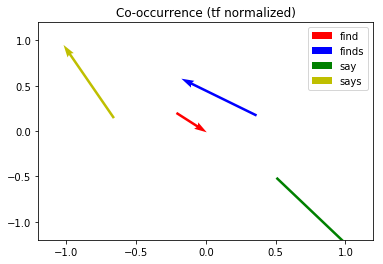

['find' 'finds' 'say' 'says']


In [284]:
#co_occurrence (tf normalized)

embedlist=[]
for i in range(4):
    #embedlist.append(word2vec[analogy_list[1][i]])
    embedlist.append(tf_cooc[tokenizer.word_index[w2visualize[i]]-1])
plt.title("Co-occurrence (tf normalized)")
draw_word_vecs(embedlist,w2visualize)    
print(w2visualize)


### Analysis
Using tf-normalized co-occurrence matrix as the embedding matrix, we can see that there are some analogy that has high similarity eventhough it has unrelated word structure. For example: (brother, sister, his, her) that has value of 0.61. This is happened because brother and sister are closely 

## 2.6 
### Discussion of the advantages of CBOW and Skipgram, the advantages of negative sampling and drawbacks of CBOW and Skipgram

CBOW tries to predict a word by context, it sees the context and maximizes the probability of the target word.
This means CBOW is good at predicting frequent words. To train CBOW a reasonably low amount of data is sufficient.
The drawback of CBOW is that whilst it will preform well at predicting frequent words it will have low accuracy for less frequent words.
this is because some words compete in the sense that they are a valid target for the same context.
The more frequent word will then be predicted.

In negative sampling we choose random words to pair with the target and have an output of 0. 
The updating of the weights is then performed on these K samples, which reduces the computational requirements.
The model does not need all observations but simply only the K sampled pairs (context + target).

Skip gram is designed to predict context. It sees the target and tries to find the context around the word. 
Skip gram is rather well suited even for rare words. Thake the example delightfull, it will try to predict something like yesterday was a day.
Whilst if CBOw would have gotten this context delightfull would have never been predicted it would have chosen more frequent words like good.
The drawback for skip gram is that it requires a large amount of data to train. This is because if we for example look at the delightfull word it will have context.
Similar nice will also have a context, delightfull day and nice day are 2 independant sets. In cbow this use of nice and delightfull would be competing since the context day has both 
delightfull and nice as targets.

## 2.7
### Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300

In [12]:
#load pretrained word embeddings of word2vec

path_word2vec = "tes\GoogleNews-vectors-negative300.bin"

word2vec = KeyedVectors.load_word2vec_format(path_word2vec, binary=True)

In [17]:
#load pretraind word embeddings of Glove
import gensim
#path = "tes\glove.6B\glove.6B.300d_converted.txt"
path = "tes\glove.6B.300d.txt"

#convert GloVe into word2vec format
gensim.scripts.glove2word2vec.get_glove_info(path)
gensim.scripts.glove2word2vec.glove2word2vec(path, "glove_converted.txt")

glove = KeyedVectors.load_word2vec_format("glove_converted.txt", binary=False)



In [265]:
#w2v and glove analogy performance
w2vanalogylist=[]
gloveanalogylist=[]
cbowanalogylist=[]
cbowdenseanalogylist=[]
skipgramanalogylist=[]
skipgramdenseanalogylist=[]

for analogy in analogy_list:
    if(analogy[0] in tokenizer.word_index and analogy[1] in tokenizer.word_index and analogy[2] in tokenizer.word_index and analogy[3] in tokenizer.word_index):
        try:
            w2vanalogy=word2vec.n_similarity([analogy[0],analogy[1]],[analogy[2],analogy[3]])
            gloveanalogy=glove.n_similarity([analogy[0],analogy[1]],[analogy[2],analogy[3]])
            cbowanalogy=analogy_check(analogy,embed_cbow_300, tokenizer.word_index )
            cbowdenseanalogy=analogy_check(analogy,embed_cbow_300_dense, tokenizer.word_index )
            skipgramanalogy=analogy_check(analogy,embed_skipgram_300, tokenizer.word_index )
            skipgramdenseanalogy=analogy_check(analogy,embed_skipgram_300_dense, tokenizer.word_index )
            
            print("w2v: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],w2vanalogy))
            print("glove: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],gloveanalogy))
            print("cbow: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],cbowanalogy))
            print("cbow_dense: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],cbowdenseanalogy))
            print("skipgram: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],skipgramanalogy))
            print("skipgram_dense: {}, {}, {}, {}: {}".format(analogy[0],analogy[1],analogy[2],analogy[3],skipgramdenseanalogy))
            
            
            w2vanalogylist.append(w2vanalogy)
            gloveanalogylist.append(gloveanalogy)
            cbowanalogylist.append(cbowanalogy)
            cbowdenseanalogylist.append(cbowdenseanalogy)
            skipgramanalogylist.append(skipgramanalogy)
            skipgramdenseanalogylist.append(skipgramdenseanalogy)
            
            
            print()
        except KeyError:
            continue
    



w2v: sudden, suddenly, usual, usually: 0.22255026056670402
glove: sudden, suddenly, usual, usually: 0.3100777731068751
cbow: sudden, suddenly, usual, usually: 0.04262983580543956
cbow_dense: sudden, suddenly, usual, usually: 0.057512587300851306
skipgram: sudden, suddenly, usual, usually: 0.025398620492292738
skipgram_dense: sudden, suddenly, usual, usually: 0.0379434827632857

w2v: bad, worse, good, better: 0.6724906513772779
glove: bad, worse, good, better: 0.6565830036364912
cbow: bad, worse, good, better: 0.08364212988123694
cbow_dense: bad, worse, good, better: 0.022567480791767187
skipgram: bad, worse, good, better: 0.014283902125049552
skipgram_dense: bad, worse, good, better: 0.06542767465641082

w2v: go, going, look, looking: 0.4437767197062708
glove: go, going, look, looking: 0.6695781772903449
cbow: go, going, look, looking: 0.11739576262876612
cbow_dense: go, going, look, looking: 0.014954370905789528
skipgram: go, going, look, looking: 0.1897161720304399
skipgram_dense: go

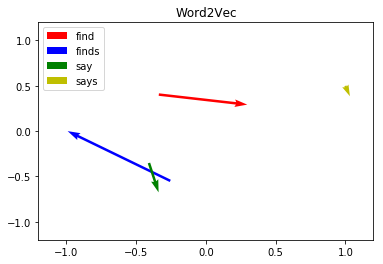

['find' 'finds' 'say' 'says']


In [276]:
#Visualize the pre-trained word embeddings
    
embedlist=[]
for i in range(4):
    embedlist.append(word2vec[w2visualize[i]])
    #embedlist.append(embed_skipgram_300[tokenizer.word_index[w2visualize[i]]-1])
len(embedlist)
plt.title("Word2Vec")
draw_word_vecs(embedlist,w2visualize)    
print(w2visualize)

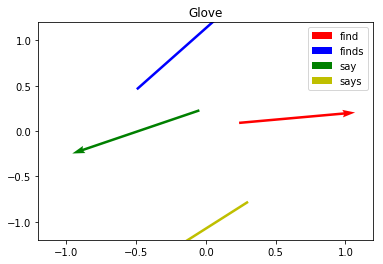

['find' 'finds' 'say' 'says']


In [278]:
#Visualize the pre-trained word embeddings
    
embedlist=[]
for i in range(4):
    embedlist.append(glove[w2visualize[i]])
    #embedlist.append(embed_skipgram_300[tokenizer.word_index[w2visualize[i]]-1])
len(embedlist)
plt.title("Glove")
draw_word_vecs(embedlist,w2visualize)    
print(w2visualize)

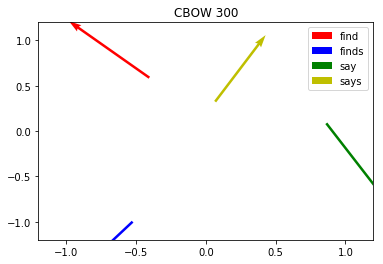

['find' 'finds' 'say' 'says']


In [273]:
#Visualize the pre-trained word embeddings
    
embedlist=[]
for i in range(4):
    #embedlist.append(word2vec[analogy_list[1][i]])
    embedlist.append(embed_cbow_300[tokenizer.word_index[w2visualize[i]]-1])
len(embedlist)
plt.title("CBOW 300")
draw_word_vecs(embedlist,w2visualize)    
print(w2visualize)

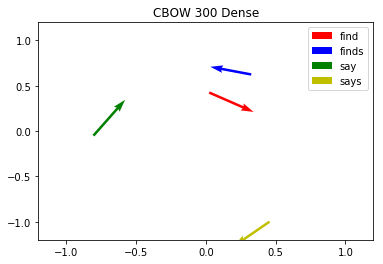

['find' 'finds' 'say' 'says']


In [274]:
#Visualize the pre-trained word embeddings
    
embedlist=[]
for i in range(4):
    #embedlist.append(word2vec[analogy_list[1][i]])
    embedlist.append(embed_cbow_300_dense[tokenizer.word_index[w2visualize[i]]-1])
len(embedlist)
plt.title("CBOW 300 Dense")
draw_word_vecs(embedlist,w2visualize)    
print(w2visualize)

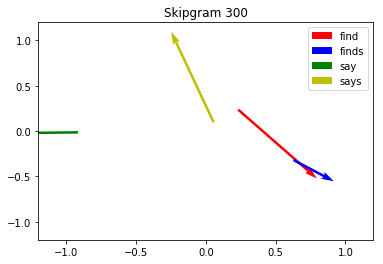

['find' 'finds' 'say' 'says']


In [272]:
#Visualize the pre-trained word embeddings
    
embedlist=[]
for i in range(4):
    #embedlist.append(word2vec[analogy_list[1][i]])
    embedlist.append(embed_skipgram_300[tokenizer.word_index[w2visualize[i]]-1])
len(embedlist)
plt.title("Skipgram 300")
draw_word_vecs(embedlist,w2visualize)    
print(w2visualize)

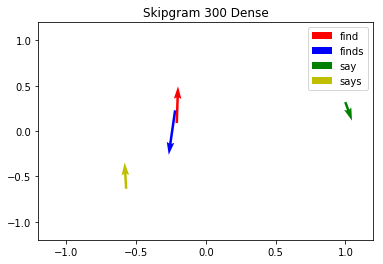

['find' 'finds' 'say' 'says']


In [275]:
#Visualize the pre-trained word embeddings
    
embedlist=[]
for i in range(4):
    #embedlist.append(word2vec[analogy_list[1][i]])
    embedlist.append(embed_skipgram_300_dense[tokenizer.word_index[w2visualize[i]]-1])
len(embedlist)
plt.title("Skipgram 300 Dense")
draw_word_vecs(embedlist,w2visualize)    
print(w2visualize)

### Analysis

From the visualization it is clear that the pretrained word embeddings outperform the skipgram and CBOW implementations as done in this assignment. 
Glove and word2vec have the vectors which one would expect to be similar reasonably parrallel to each other.
Where for example the CBOW300 implementation has all vectors pointing in completely different directions thus showing randomness. It seems like training of CBOW300 was cut off to fast and should have been trained longer. 
Skip gram does perform resoanbly well with similar words being close to each other.

Comparison performance with your own trained word embeddings

In [291]:
analogy_list
#print(len(analogy_list))

[array(['happy', 'unhappy', 'pleasant', 'unpleasant'], dtype='<U10'),
 array(['sudden', 'suddenly', 'usual', 'usually'], dtype='<U8'),
 array(['bad', 'worse', 'good', 'better'], dtype='<U6'),
 array(['go', 'going', 'look', 'looking'], dtype='<U7'),
 array(['he', 'she', 'his', 'her'], dtype='<U3'),
 array(['brother', 'sister', 'his', 'her'], dtype='<U7'),
 array(['listen', 'listening', 'look', 'looking'], dtype='<U9'),
 array(['saying', 'said', 'thinking', 'thought'], dtype='<U8'),
 array(['bird', 'birds', 'cat', 'cats'], dtype='<U5'),
 array(['good', 'better', 'old', 'older'], dtype='<U6'),
 array(['good', 'better', 'quick', 'quicker'], dtype='<U7'),
 array(['large', 'largest', 'good', 'best'], dtype='<U7'),
 array(['happy', 'unhappy', 'comfortable', 'uncomfortable'], dtype='<U13'),
 array(['falling', 'fell', 'knowing', 'knew'], dtype='<U7'),
 array(['walk', 'walking', 'think', 'thinking'], dtype='<U8'),
 array(['child', 'children', 'cat', 'cats'], dtype='<U8'),
 array(['dog', 'dogs', 

In [ ]:
 #47